In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress, spearmanr
import matplotlib.pyplot as plt
import warnings

# Load Data

In [2]:
catalog = pd.read_csv('./catalog.csv')
catalog = catalog[catalog['ID'] != 11024].reset_index(drop=True) # Wearing time less then 1 hour
catalog = catalog[catalog['ID'] != 12001].reset_index(drop=True) # Incorrect sensor orientation

with warnings.catch_warnings(): # Excel Header cannot be parsed
    warnings.simplefilter("ignore")
    sa_data = pd.read_excel('./SAh_OKIE_DB_20250303.xlsx', sheet_name=0, header=0, engine='openpyxl')

sa_data = sa_data.rename(columns={'id': 'ID'})

# Analysis

In [3]:
def is_overlapping(start1, end1, start2, end2):
    return not (end1 < start2 or end2 < start1)

In [4]:
results_df = pd.DataFrame()

for index, subject in catalog.iterrows():   
    
    ID = subject['ID']
    sensor = subject['sensor_attachment_su']
    diary = subject['diary']
    
    if (sensor == 'lumbar') and (diary == True):
        # Load Data
        gait_sequences = pd.read_csv(f'./03_Ergebnisse/{ID}/gait_sequences.csv')
        subject_diary = pd.read_csv(f'./03_Ergebnisse/{ID}/BTB_{ID}.csv')

        # Initialize counters
        true_positive, false_positive, false_negative = 0, 0, 0

        # Loop over gait sequences and find true/false positives
        for _, row_a in gait_sequences.iterrows():
            overlap_found = any(is_overlapping(row_a['start'], row_a['end'], row_b['start'], row_b['end']) for _, row_b in subject_diary.iterrows())
            if overlap_found:
                true_positive += 1
            else:
                false_positive += 1

        # Loop over diary and find false negatives
        for _, row_b in subject_diary.iterrows():
            overlap_found = any(is_overlapping(row_b['start'], row_b['end'], row_a['start'], row_a['end']) for _, row_a in gait_sequences.iterrows())
            if not overlap_found:
                false_negative += 1

        # Expand results_df
        sample_results = pd.DataFrame(
            data=np.array([[ID, true_positive, false_positive, false_negative]]),
            columns=['ID', 'True Positive', 'False Positive', 'False Negative']
        )
        results_df = pd.concat([results_df, sample_results], axis=0, ignore_index=True)
        

In [5]:
sum_row = results_df.sum(axis=0)
results_df.loc[len(results_df.index)] = sum_row
results_df['ID'] = results_df['ID'].astype('object')
results_df.loc[len(results_df)-1, 'ID'] = 'SUM'

# Performance

In [6]:
def precision(row): # Positive Predictive Value (PPV)
    if row['True Positive'] == 0 and row['False Positive'] == 0: # If Division by Zero
        return 1
    return row['True Positive'] / (row['True Positive'] + row['False Positive'])

In [7]:
def recall(row): # Sensitivity
    if row['True Positive'] == 0 and row['False Negative'] == 0: # If Division by Zero
        return 1
    return row['True Positive'] / (row['True Positive'] + row['False Negative'])

In [8]:
def f1_score(row):
    p = precision(row)
    r = recall(row)
    if p + r == 0:
        return 0  # Special case for division by zero
    return 2 * p * r / (p + r)

In [9]:
results_df['Precision / PPV'] = results_df.apply(precision, axis=1)
results_df['Recall / Sensitivity'] = results_df.apply(recall, axis=1)
results_df['F1 Score'] = results_df.apply(f1_score, axis=1)
results_df = results_df.round(2)

In [10]:
results_df.set_index('ID')

,True Positive,False Positive,False Negative,Precision / PPV,Recall / Sensitivity,F1 Score
ID,,,,,,
11005,0,2,0,0.00,1.00,0.00
11014,0,1,3,0.00,0.00,0.00
11041,257,303,2,0.46,0.99,0.63
11047,2,6,18,0.25,0.10,0.14
11062,1,5,25,0.17,0.04,0.06
11065,0,0,2,1.00,0.00,0.00
11074,2,8,5,0.20,0.29,0.24
11083,3,24,17,0.11,0.15,0.13
11085,0,28,4,0.00,0.00,0.00


In [11]:
results_df.set_index('ID').to_csv('./results_diary.csv')

## Regression

In [12]:
functional_data = pd.merge(results_df, sa_data[['ID', 'bi_postop_3', 'charmi_postop_3']], on='ID', how='left')
functional_data = functional_data.dropna()
functional_data.loc[functional_data['charmi_postop_3'] == 11, 'charmi_postop_3'] = np.nan

### Spearman

#### Walking Bouts

In [13]:
x_wb = results_df[['True Positive', 'False Positive']].sum(axis=1).values
y_wb = results_df['F1 Score'].values
statistic, p_value = spearmanr(x_wb, y_wb)

print("statistic:", statistic)
print("p-value:", p_value)

statistic: 0.836713187537537
p-value: 6.512295354780212e-07


#### CHARMI

In [14]:
x_charmi = functional_data.dropna()['charmi_postop_3'].values
y_charmi = functional_data.dropna()['F1 Score'].values
statistic, p_value = spearmanr(x_charmi, y_charmi)

print("statistic:", statistic)
print("p-value:", p_value)

statistic: 0.8049350406379658
p-value: 1.8669285524795624e-05


#### Barthel Index

In [15]:
x_bi = functional_data['bi_postop_3'].values
y_bi = functional_data['F1 Score'].values
statistic, p_value = spearmanr(x_bi, y_bi)

print("statistic:", statistic)
print("p-value:", p_value)

statistic: 0.8005474360893678
p-value: 1.3101536138120784e-05


### Figure

7.4586108829849e-07
2.92462754422328e-05
1.3723399120914972e-05


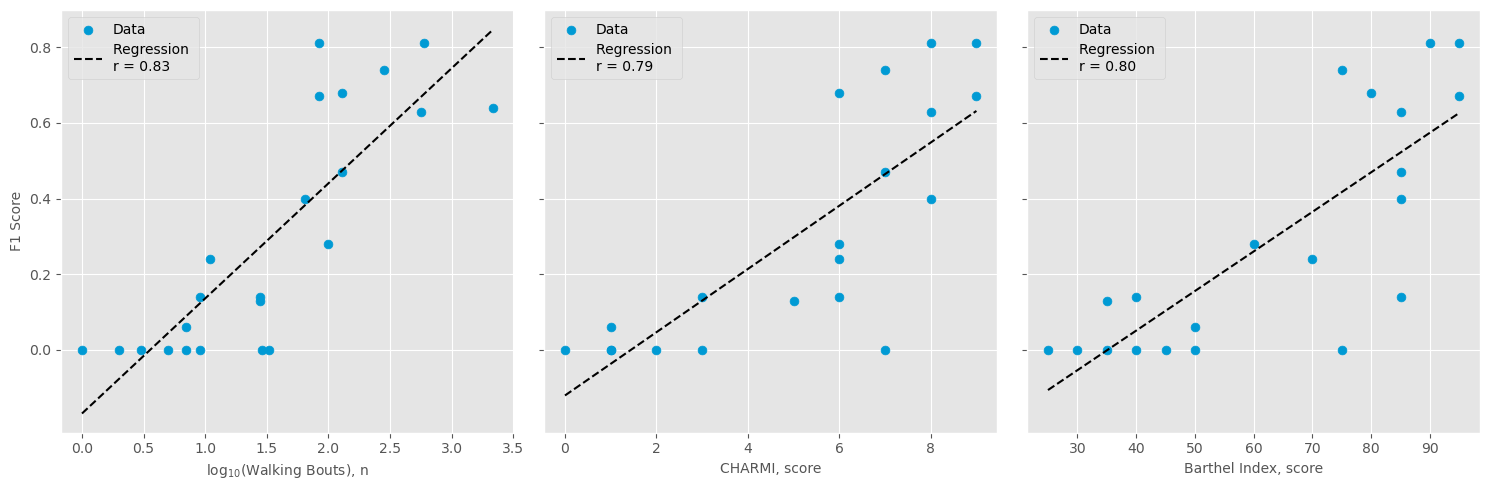

In [16]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
data = [
    (np.log10(x_wb+1), y_wb, "log$_{10}$(Walking Bouts), n"),
    (x_charmi, y_charmi, "CHARMI, score"),
    (x_bi, y_bi, "Barthel Index, score")
]

for i, (x, y, xlabel) in enumerate(data):
    ax = axes[i]
    ax.scatter(x, y, color='#009AD4', s=40, marker='o', label='Data')
    slope, intercept, r_value, p_value, _ = linregress(x, y)
    print(p_value)
    line = slope * x + intercept
    ax.plot([min(x), max(x)], [min(line), max(line)], color='black', linestyle='--', label=f'Regression \nr = {r_value:.2f}')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.legend(loc='upper left')

axes[0].set_ylabel('F1 Score', fontsize=10)
axes[0].set_yticks(np.arange(0, 1, 0.2).round(1))

plt.tight_layout()
plt.savefig('./diary_regression.png', dpi=400, bbox_inches='tight')
plt.show();